In [155]:
import ast
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
from fiona.crs import from_epsg
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [3]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [227]:
facilityQuery = 'SELECT COUNT(zipcodes),zipcodes FROM nycasthmasdismissals GROUP BY zipcodes'
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
facilityData
facilities = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [228]:
facilities.columns = ['counts','ZIPCODE']

In [229]:
df = gpd.read_file('ZIP_CODE_040114\ZIP_CODE_040114.shp')

In [230]:
df.head(1)

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."


In [231]:
df['centroid'] = df.geometry.centroid

In [123]:
# No need to switch in lat/long
# df.crs = from_epsg(2263)
# df_latlong = df.to_crs(epsg=4326).centroid

In [233]:
df['centroid_lat_long'] = df_latlong

In [234]:
df_new = df[['ZIPCODE','centroid']]
df_new.ZIPCODE = df_new.ZIPCODE.astype(int)

In [235]:
merged = pd.merge(facilities,df_new,on='ZIPCODE')

In [236]:
merged['Easting'] = [merged.centroid[i].x for i in range (0,len(merged))]
merged['Northing'] = [merged.centroid[i].y for i in range (0,len(merged))]

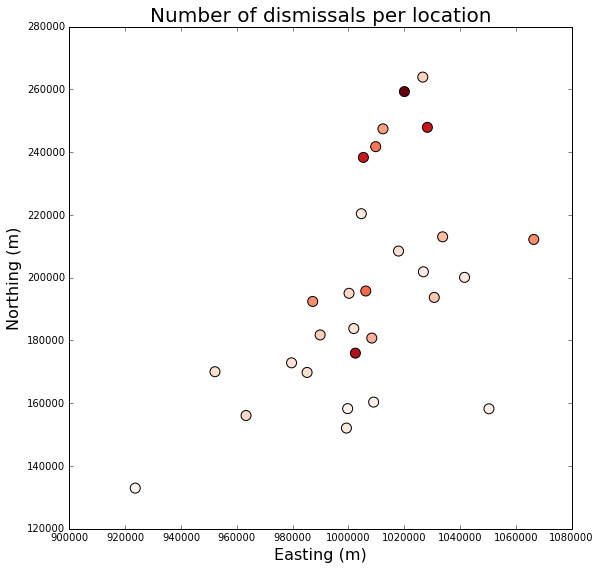

In [237]:
plt.figure(figsize=(9,9))
plt.scatter(merged.Easting, merged.Northing, s=100, c=merged['counts'], cmap='Reds')
plt.xlabel('Easting (m)',size=16)
plt.ylabel('Northing (m)',size=16)
plt.title('Number of dismissals per location',size=20)
plt.show()

## Figure 1
Shows the spatial distribution of asthma related dismissals in NYC zipcodes 

In [148]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [159]:
x = np.asarray(merged[['counts','Easting','Northing']])

In [224]:
lag = 10000
mysv = SV( x, np.arange(1, 200000, lag),50000)

In [225]:
mysv

array([[  1.00000000e+00,   1.00010000e+04,   2.00010000e+04,
          3.00010000e+04,   4.00010000e+04,   5.00010000e+04,
          6.00010000e+04,   7.00010000e+04,   8.00010000e+04,
          9.00010000e+04,   1.00001000e+05,   1.10001000e+05,
          1.20001000e+05,   1.30001000e+05,   1.40001000e+05,
          1.50001000e+05,   1.60001000e+05,   1.70001000e+05,
          1.80001000e+05,   1.90001000e+05],
       [  1.09480976e+09,   1.08118303e+09,   1.09651034e+09,
          1.09880544e+09,   1.13747275e+09,   1.15638549e+09,
          1.29963658e+09,   1.36673437e+09,   1.39107397e+09,
          1.52360844e+09,   1.62755581e+09,   1.89676295e+09,
          2.21259975e+09,   2.80263253e+09,   3.20645329e+09,
          3.07820305e+09,   1.96133638e+09,   1.72911602e+09,
          3.13871114e+09,   3.13871114e+09]])

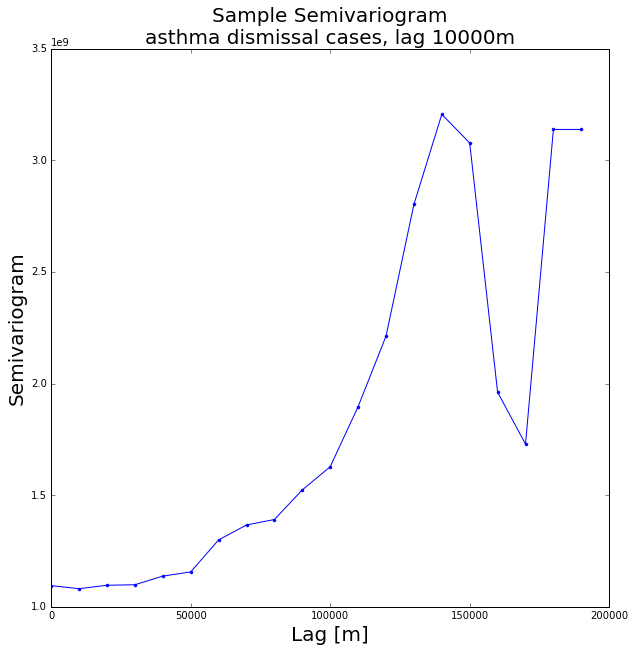

In [226]:
plt.figure(figsize=(10,10))
plt.plot( mysv[0], mysv[1], '.-' )
plt.xlabel('Lag [m]', fontsize=20)
plt.ylabel('Semivariogram', fontsize=20)
plt.title('Sample Semivariogram\nasthma dismissal cases, lag %dm'%lag, fontsize=20)

## Figure 2
Shows the semivariogram of asthma related dismissal cases. We observe high correlation among close points (values in y-axis closee to 1). The correlation decreases as the lag increases. The gap after the lag of 150,000 is probably due to some implementation error. 

In [ ]:
#@Review: comment on what's happening, what you infer from plot trends? See solution.